In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Suppress Info,Warning

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input
from keras.layers import Embedding
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix, \
                    accuracy_score, roc_curve, auc

import matplotlib.pyplot as plt
%matplotlib inline

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
df = pd.read_csv('data/final.zip', compression='zip')
df.head()

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,TOXIC,...,word_counts,unique_word_counts,clean_text,tokenized,tokenized_no_stopwords,tokenized_stemmed,tokenized_pos,tokenized_lemmatized,tokenized_lemmatized_pos,tokenized_bigram
0,0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,...,43,41,explanation why the edits made under my userna...,"['explanation', 'why', 'the', 'edits', 'made',...","['explanation', 'edits', 'made', 'username', '...","['explan', 'edit', 'made', 'usernam', 'hardcor...","[('explanation', 'NN'), ('edits', 'NNS'), ('ma...","['explanation', 'edits', 'made', 'username', '...","['explanation', 'edits', 'make', 'username', '...","[('explanation', 'edits'), ('edits', 'made'), ..."
1,1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,...,17,17,daww he matches this background colour i am se...,"['daww', 'he', 'matches', 'this', 'background'...","['daww', 'matches', 'background', 'colour', 's...","['daww', 'match', 'background', 'colour', 'see...","[('daww', 'NN'), ('matches', 'NNS'), ('backgro...","['daww', 'match', 'background', 'colour', 'see...","['daww', 'match', 'background', 'colour', 'see...","[('daww', 'matches'), ('matches', 'background'..."
2,2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,...,42,39,hey man i am really not trying to edit war it ...,"['hey', 'man', 'i', 'am', 'really', 'not', 'tr...","['hey', 'man', 'really', 'trying', 'edit', 'wa...","['hey', 'man', 'realli', 'tri', 'edit', 'war',...","[('hey', 'NN'), ('man', 'NN'), ('really', 'RB'...","['hey', 'man', 'really', 'trying', 'edit', 'wa...","['hey', 'man', 'really', 'try', 'edit', 'war',...","[('hey', 'man'), ('man', 'really'), ('really',..."
3,3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,...,113,82,more i cannot make any real suggestions on im...,"['more', 'i', 'can', 'not', 'make', 'any', 're...","['make', 'real', 'suggestions', 'improvement',...","['make', 'real', 'suggest', 'improv', 'wonder'...","[('make', 'VB'), ('real', 'JJ'), ('suggestions...","['make', 'real', 'suggestion', 'improvement', ...","['make', 'real', 'suggestion', 'improvement', ...","[('make', 'real'), ('real', 'suggestions'), ('..."
4,4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,...,13,13,you sir are my hero any chance you remember wh...,"['you', 'sir', 'are', 'my', 'hero', 'any', 'ch...","['sir', 'hero', 'chance', 'remember', 'page']","['sir', 'hero', 'chanc', 'rememb', 'page']","[('sir', 'NN'), ('hero', 'NN'), ('chance', 'NN...","['sir', 'hero', 'chance', 'remember', 'page']","['sir', 'hero', 'chance', 'remember', 'page']","[('sir', 'hero'), ('hero', 'chance'), ('chance..."


In [8]:
# Ci sono commenti che sono solo numeri
df['clean_text'] = df['clean_text'].apply(lambda x: str(x).rstrip())

In [9]:
df['comment_text'][0], df['clean_text'][0]

("Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
 'explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now')

In [4]:
#return dictionary with word: embedding_vector
def load_embedding(fname):
    embeddings_index = {}
    f = open(fname, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            embedding_vector = np.asarray(values[1:], dtype='float32')
        except:
            pass
        
        embeddings_index[word] = embedding_vector
    f.close()

    return embeddings_index

In [38]:
def build_CNN_model(word_index, embeddings_index, N_CLASSES, MAX_SEQUENCE_LENGTH, EMBEDDING_DIMS, CONV_LAYERS):
    print('Build model...')
    
    filters=128
    kernel_size=5

    model = Sequential()
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIMS))

    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    model.add(Embedding(len(word_index) + 1,
                              EMBEDDING_DIMS,
                              weights=[embedding_matrix],
                              input_length=MAX_SEQUENCE_LENGTH,
                              trainable=False))

    for i in range(0, CONV_LAYERS):
        model.add(Conv1D(filters, kernel_size, activation='relu'))
        
        if i != CONV_LAYERS-1: 
            model.add(MaxPooling1D())

    model.add(GlobalMaxPooling1D())

    model.add(Dropout(0.2))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(N_CLASSES, activation='sigmoid'))
  
    return model

# Binary Task (toxic vs no_toxic)

In [42]:
text = df.clean_text.values
target = df.TOXIC.values

#Parameters
N_CLASSES=1
MAX_WORDS=20000
MAX_SEQUENCE_LENGTH=200
EMBEDDING_DIMS = 50
CONV_LAYERS=2

tokenizer = Tokenizer(num_words=MAX_WORDS) 
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text) 
sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index
embeddings_index = load_embedding("glove.6B.50d.txt")
#embeddings_index = load_embedding("./wiki.simple.vec")

x_train, x_test, y_train, y_test = train_test_split(sequences, target, test_size=0.2, random_state=100)

print(f'train sequences {len(x_train)}')
print(f'test sequences {len(x_test)}')
print(f'x_train shape: {x_train.shape}')
print(f'x_test shape: {x_test.shape}')

train sequences 178839
test sequences 44710
x_train shape: (178839, 200)
x_test shape: (44710, 200)


In [43]:
x_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [44]:
model = build_CNN_model(word_index, embeddings_index, N_CLASSES, MAX_SEQUENCE_LENGTH, EMBEDDING_DIMS, CONV_LAYERS)
model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
model.summary()

Build model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 50)           15550050  
                                                                 
 conv1d_1 (Conv1D)           (None, 196, 128)          32128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 128)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 94, 128)           82048     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 128

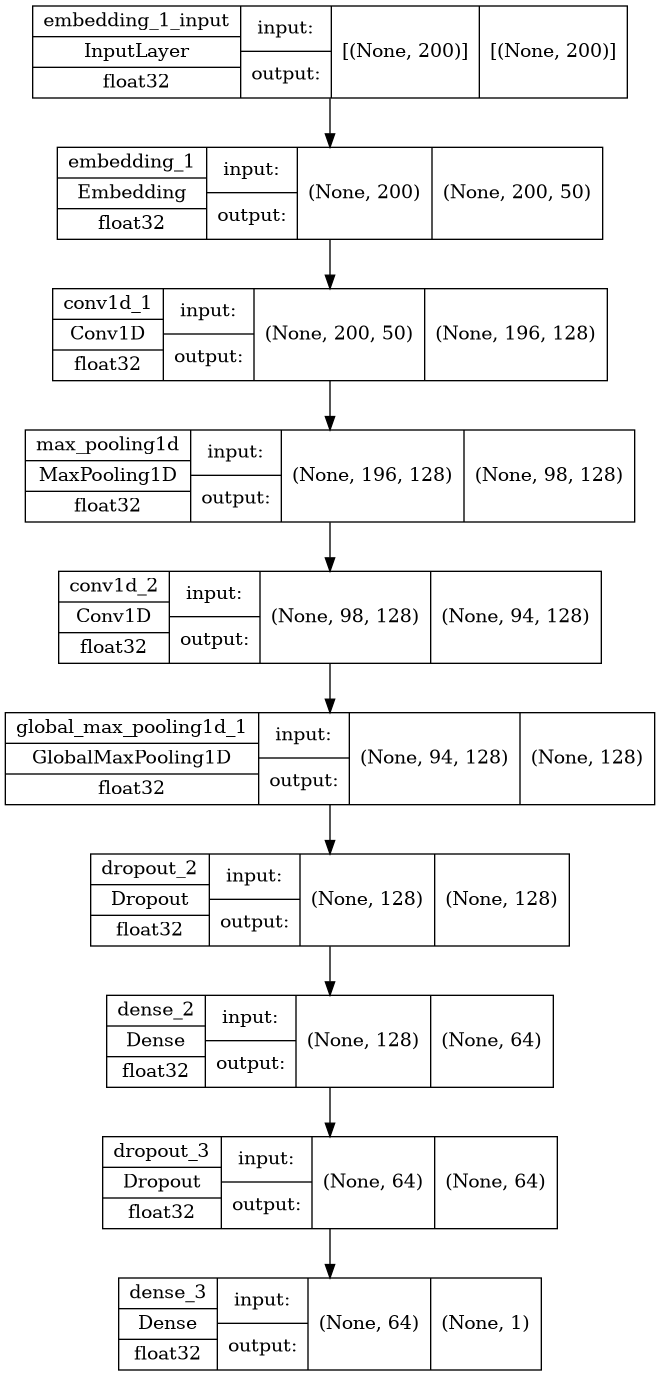

In [45]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [48]:
epochs = 10
batch_size=1024

history = model.fit(x_train, y_train,
          validation_split=0.1,
          batch_size=batch_size,
          epochs=epochs)

Epoch 1/10
158/158 [==============================] - 11s 73ms/step - loss: 0.1287 - accuracy: 0.9498 - val_loss: 0.1385 - val_accuracy: 0.9460
Epoch 2/10
158/158 [==============================] - 11s 72ms/step - loss: 0.1224 - accuracy: 0.9525 - val_loss: 0.1371 - val_accuracy: 0.9464
Epoch 3/10
158/158 [==============================] - 11s 72ms/step - loss: 0.1143 - accuracy: 0.9552 - val_loss: 0.1416 - val_accuracy: 0.9467
Epoch 4/10
158/158 [==============================] - 12s 74ms/step - loss: 0.1067 - accuracy: 0.9583 - val_loss: 0.1432 - val_accuracy: 0.9474
Epoch 5/10
158/158 [==============================] - 11s 73ms/step - loss: 0.0972 - accuracy: 0.9620 - val_loss: 0.1521 - val_accuracy: 0.9475
Epoch 6/10
158/158 [==============================] - 11s 72ms/step - loss: 0.0900 - accuracy: 0.9650 - val_loss: 0.1459 - val_accuracy: 0.9465
Epoch 7/10
158/158 [==============================] - 11s 72ms/step - loss: 0.0843 - accuracy: 0.9675 - val_loss: 0.1486 - val_accuracy:

In [49]:
history.history

{'loss': [0.1286928951740265,
  0.1224152222275734,
  0.11427410691976547,
  0.10673554241657257,
  0.09717711061239243,
  0.09003257006406784,
  0.08433288335800171,
  0.07654620707035065,
  0.0705864354968071,
  0.0642368271946907],
 'accuracy': [0.9498369097709656,
  0.9525209069252014,
  0.9552048444747925,
  0.958267867565155,
  0.9620204567909241,
  0.9649653434753418,
  0.967525064945221,
  0.9706874489784241,
  0.972886860370636,
  0.9758255481719971],
 'val_loss': [0.13851939141750336,
  0.13705123960971832,
  0.14160941541194916,
  0.14323145151138306,
  0.1521344631910324,
  0.14589883387088776,
  0.14863534271717072,
  0.16526849567890167,
  0.17333249747753143,
  0.19923610985279083],
 'val_accuracy': [0.9460076093673706,
  0.9464325904846191,
  0.9467009902000427,
  0.9473943114280701,
  0.9474614262580872,
  0.9464549422264099,
  0.9446879625320435,
  0.9460747241973877,
  0.9448668956756592,
  0.9452918767929077]}

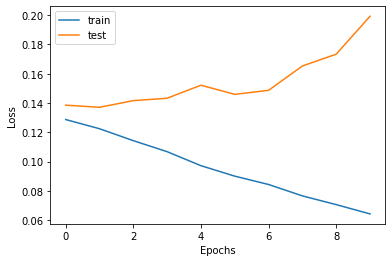

In [50]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

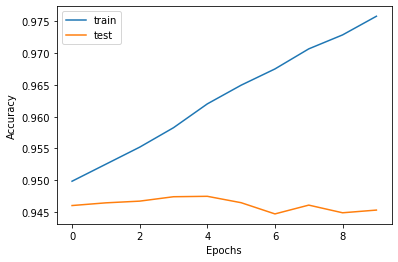

In [51]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [52]:
y_prob = model.predict(x_test)
y_pred = y_prob.round()

In [53]:
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     40196
           1       0.81      0.60      0.69      4514

    accuracy                           0.95     44710
   macro avg       0.88      0.79      0.83     44710
weighted avg       0.94      0.95      0.94     44710



array([[39542,   654],
       [ 1792,  2722]])

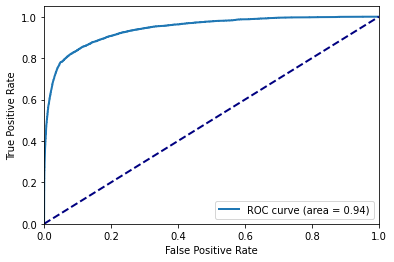

In [55]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Multi-label classification task
  toxic, severe_toxic, obscene, threat, insult, identity_hate

In [56]:
text = df.clean_text.values
target = df[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].values

N_CLASSES=target.shape[1]
MAX_WORDS=20000
MAX_SEQUENCE_LENGTH=200
EMBEDDING_DIMS = 50
CONV_LAYERS=4

tokenizer = Tokenizer(num_words=MAX_WORDS) 
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text) 
sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index
embeddings_index = load_embedding("./glove.6B.50d.txt")
#embeddings_index = load_embedding("./wiki.simple.vec")

x_train, x_test, y_train, y_test = train_test_split(sequences, target, test_size=0.2, random_state=100)

In [57]:
model = build_CNN_model(word_index, embeddings_index, N_CLASSES, MAX_SEQUENCE_LENGTH, EMBEDDING_DIMS, CONV_LAYERS)
model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(),  tf.keras.metrics.Recall()]
)
model.summary()

Build model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 50)           15550050  
                                                                 
 conv1d_3 (Conv1D)           (None, 196, 128)          32128     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 98, 128)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 94, 128)           82048     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 47, 128)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 43,

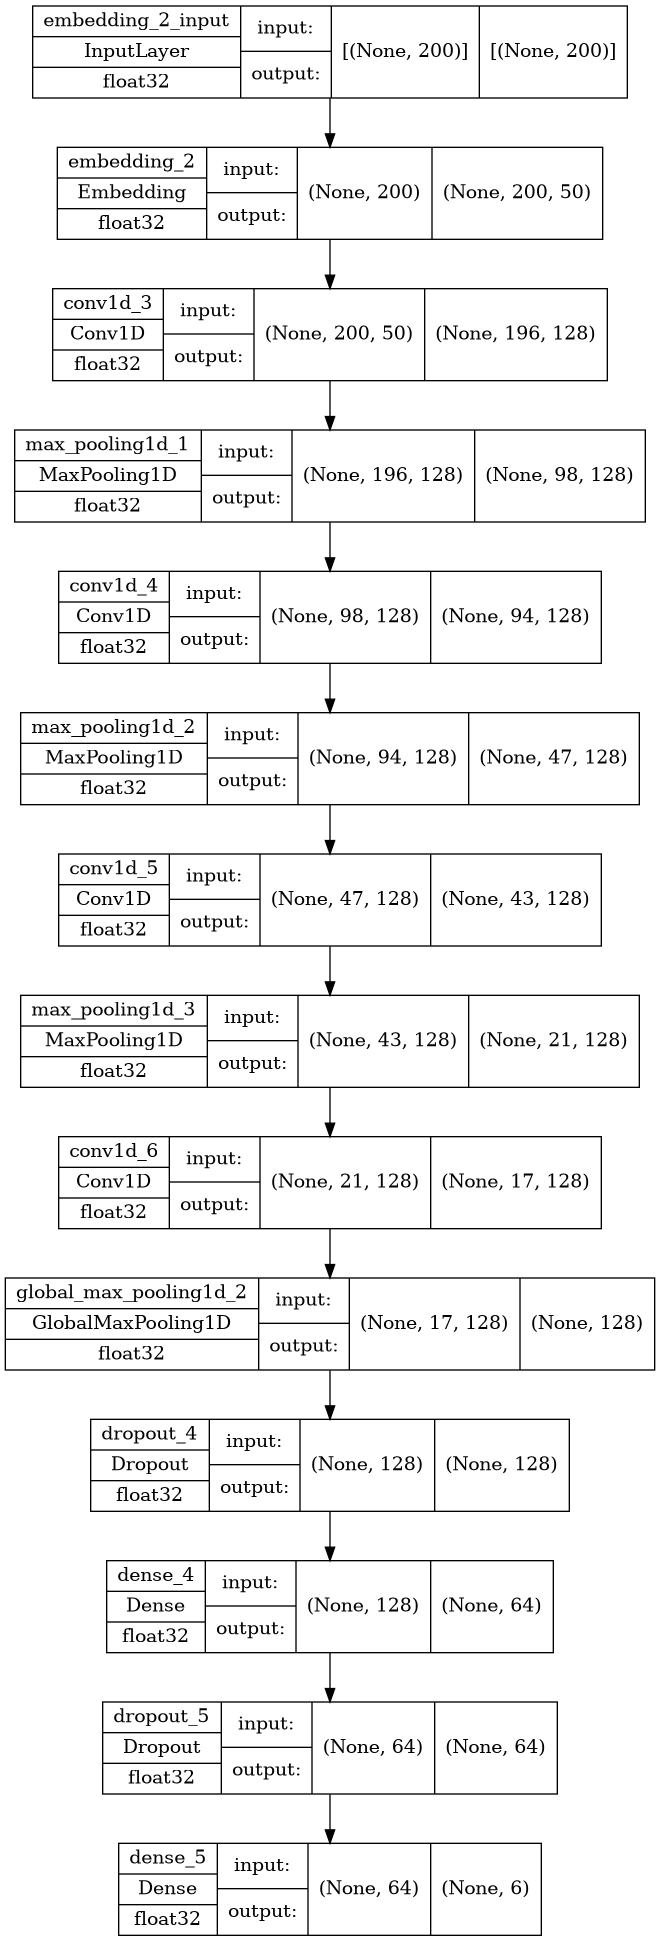

In [58]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [59]:
epochs = 10
batch_size=1024

history = model.fit(x_train, y_train,
          validation_split=0.1,
          batch_size=batch_size,
          epochs=epochs)

Epoch 1/10
158/158 [==============================] - 16s 97ms/step - loss: 0.1456 - auc: 0.8038 - precision: 0.2319 - recall: 0.0543 - val_loss: 0.0993 - val_auc: 0.9209 - val_precision: 0.6145 - val_recall: 0.2635
Epoch 2/10
158/158 [==============================] - 15s 94ms/step - loss: 0.0966 - auc: 0.9179 - precision: 0.6879 - recall: 0.3079 - val_loss: 0.0840 - val_auc: 0.9387 - val_precision: 0.7469 - val_recall: 0.3529
Epoch 3/10
158/158 [==============================] - 15s 94ms/step - loss: 0.0883 - auc: 0.9324 - precision: 0.7370 - recall: 0.3646 - val_loss: 0.0819 - val_auc: 0.9407 - val_precision: 0.7622 - val_recall: 0.3702
Epoch 4/10
158/158 [==============================] - 15s 95ms/step - loss: 0.0844 - auc: 0.9385 - precision: 0.7606 - recall: 0.3813 - val_loss: 0.0816 - val_auc: 0.9430 - val_precision: 0.8202 - val_recall: 0.3183
Epoch 5/10
158/158 [==============================] - 15s 95ms/step - loss: 0.0821 - auc: 0.9426 - precision: 0.7685 - recall: 0.3949 - 

In [60]:
history.history

{'loss': [0.14564192295074463,
  0.0965939536690712,
  0.08829116076231003,
  0.08442135155200958,
  0.08209161460399628,
  0.07932242006063461,
  0.07629510015249252,
  0.0739426463842392,
  0.07097034901380539,
  0.06733748316764832],
 'auc': [0.8038244843482971,
  0.9178621172904968,
  0.9323911666870117,
  0.9385221600532532,
  0.9425844550132751,
  0.9469931125640869,
  0.9519538283348083,
  0.9551353454589844,
  0.9594915509223938,
  0.963871955871582],
 'precision': [0.23190829157829285,
  0.6878591179847717,
  0.7369908094406128,
  0.7605798840522766,
  0.7684943675994873,
  0.7778366208076477,
  0.7835623621940613,
  0.7888022065162659,
  0.7924889922142029,
  0.8026146292686462],
 'recall': [0.05428827181458473,
  0.30789443850517273,
  0.3646427392959595,
  0.38133177161216736,
  0.39494577050209045,
  0.41068434715270996,
  0.4304204285144806,
  0.4493738114833832,
  0.47369450330734253,
  0.5045846104621887],
 'val_loss': [0.09933286905288696,
  0.08400452136993408,
  0.08

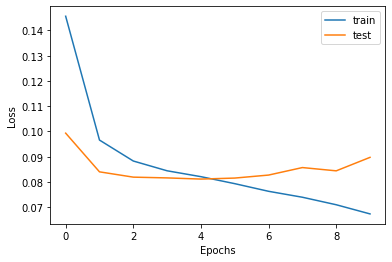

In [61]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

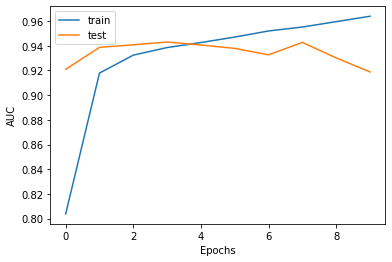

In [62]:
plt.plot(history.history['auc'], label='train')
plt.plot(history.history['val_auc'], label='test')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

In [63]:
y_prob = model.predict(x_test)
y_pred = y_prob.round()

In [65]:
print(classification_report(y_test, y_pred))
multilabel_confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.79      0.40      0.53      4301
           1       0.58      0.15      0.24       383
           2       0.79      0.42      0.55      2438
           3       0.00      0.00      0.00       129
           4       0.74      0.36      0.49      2264
           5       0.00      0.00      0.00       438

   micro avg       0.77      0.36      0.50      9953
   macro avg       0.48      0.22      0.30      9953
weighted avg       0.72      0.36      0.48      9953
 samples avg       0.04      0.03      0.03      9953



array([[[39948,   461],
        [ 2580,  1721]],

       [[44286,    41],
        [  326,    57]],

       [[41997,   275],
        [ 1413,  1025]],

       [[44581,     0],
        [  129,     0]],

       [[42156,   290],
        [ 1440,   824]],

       [[44272,     0],
        [  438,     0]]])

In [66]:
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')

Accuracy score: 0.9034891523149183


In [67]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(N_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [68]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [69]:
print(roc_auc["micro"])

0.9395571112671293


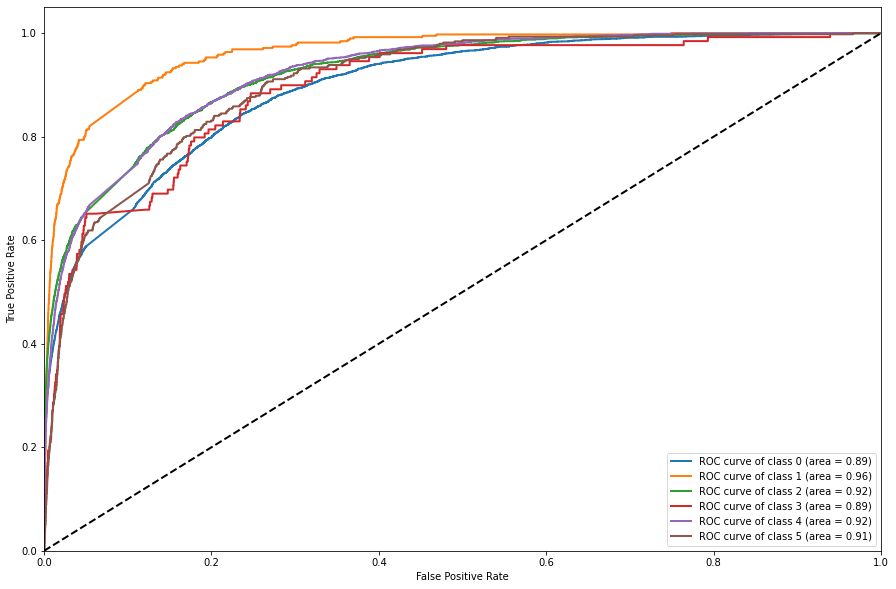

In [70]:
plt.figure(figsize=(15,10))
for i in range(N_CLASSES):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()